In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [142]:
TRAIN = pd.read_csv('../Data/train.csv')
TEST = pd.read_csv('../Data/test.csv')

Train Dataset:

In [143]:
TRAIN

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


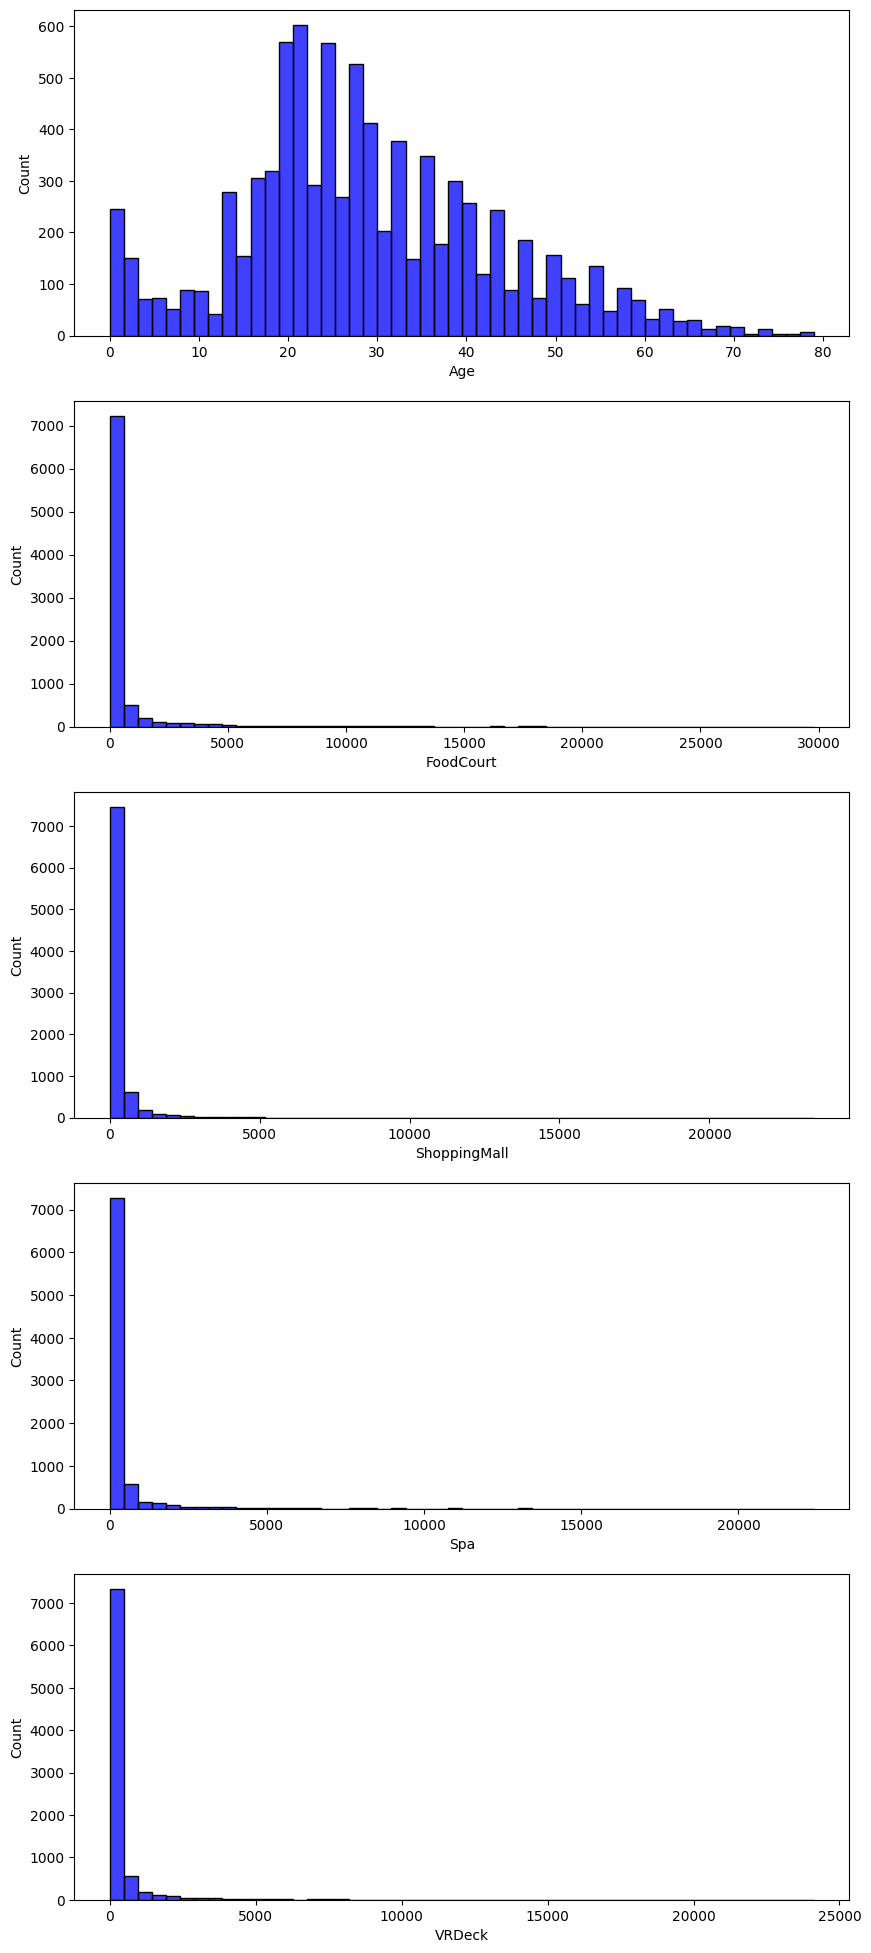

In [144]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(TRAIN['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(TRAIN['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(TRAIN['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(TRAIN['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(TRAIN['VRDeck'], color='b', bins=50, ax=ax[4]);

Split Cabin column into Deck/Cabin_num/Side

In [145]:
TRAIN[["Deck", "Cabin_num", "Side"]] = TRAIN["Cabin"].str.split("/", expand=True)
try:
    TRAIN = TRAIN.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

Rearrenge columns

In [146]:
cols = list(TRAIN.columns.values)
cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported',
 'Deck',
 'Cabin_num',
 'Side']

In [147]:
TRAIN = TRAIN[['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt',
 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Deck', 'Cabin_num', 'Side', 'Transported']]

We convert the columns from categorical and boolean to int

In [148]:
categorical_col = ['HomePlanet', 'Destination', 'Name', 'Deck', 'Side']
bool_col = ['CryoSleep', 'VIP', 'Transported']

In [149]:
TRAIN.loc[:, categorical_col] = TRAIN[categorical_col].apply(lambda x: pd.Categorical(x).codes)
TRAIN.loc[:, bool_col] = TRAIN[bool_col].replace({True: 1, False: 0})

In [150]:
TRAIN.iloc[:, 1:].describe(include='all')

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side,Transported
count,8693.0,8476.0,8693.0,8514.000000,8490.0,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.0,8693.0,8494,8693.0,8693.000000
unique,4.0,2.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,8474.0,9.0,1817,3.0,NaN
top,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,5.0,82,1.0,NaN
freq,4602.0,5439.0,5915.0,NaN,8291.0,NaN,NaN,NaN,NaN,NaN,200.0,2794.0,28,4288.0,NaN
mean,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN,NaN,NaN,0.503624
std,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN,NaN,NaN,0.500016
min,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN,NaN,NaN,1.000000


In [151]:
TRAIN.head(10)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side,Transported
0,0001_01,1,0.0,2,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252,1,0,0,0
1,0002_01,0,0.0,2,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502,5,0,1,1
2,0003_01,1,0.0,2,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457,0,0,1,0
3,0003_02,1,0.0,2,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149,0,0,1,0
4,0004_01,0,0.0,2,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319,5,1,1,1
5,0005_01,0,0.0,1,44.0,0.0,0.0,483.0,0.0,291.0,0.0,6878,5,0,0,1
6,0006_01,0,0.0,2,26.0,0.0,42.0,1539.0,3.0,0.0,0.0,1155,5,2,1,1
7,0006_02,0,1.0,2,28.0,0.0,0.0,0.0,0.0,0.0,NaN,1453,6,0,1,1
8,0007_01,0,0.0,2,35.0,0.0,0.0,785.0,17.0,216.0,0.0,556,5,3,1,1
9,0008_01,1,1.0,0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,2864,1,1,0,1


We are going to imput the missing data in two ways: if int column we use the most frequent observation. If float, we use the mean. We start by removing the PassengedId and Name columns

In [152]:
TRAIN = TRAIN.drop('PassengerId', axis=1)
TRAIN = TRAIN.drop('Name', axis=1)
TRAIN

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Transported
0,1,0.0,2,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0,0.0,2,24.0,0.0,109.0,9.0,25.0,549.0,44.0,5,0,1,1
2,1,0.0,2,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0
3,1,0.0,2,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0
4,0,0.0,2,16.0,0.0,303.0,70.0,151.0,565.0,2.0,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0.0,0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,98,0,0
8689,0,1.0,1,18.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1499,1,0
8690,0,0.0,2,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,6,1500,1,1
8691,1,0.0,0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,4,608,1,0


In [153]:
TRAIN_IMPUT = TRAIN.fillna(TRAIN.mode().iloc[0])

In [154]:
TRAIN_IMPUT.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side,Transported
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.626711,0.349362,1.431497,28.728517,0.022892,220.009318,448.434027,169.572300,304.588865,298.261820,4.183941,0.470378,0.503624
std,0.827623,0.476796,0.886083,14.355438,0.149568,660.519050,1595.790627,598.007164,1125.562559,1134.126417,1.928570,0.543084,0.500016
min,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,40.000000,6.000000,1.000000,1.000000
max,2.000000,1.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,7.000000,1.000000,1.000000


Correlations with 'Transport'

In [155]:
correlations = np.array([[abs(pointbiserialr(TRAIN_IMPUT[col].astype(int), TRAIN_IMPUT.Transported)[0]), col] for col in TRAIN_IMPUT.iloc[:, 1:-1]])

In [156]:
correlations[correlations[:, 0].argsort()]

array([['0.009391027784015257', 'ShoppingMall'],
       ['0.03726083226661534', 'VIP'],
       ['0.04401195477152036', 'Cabin_num'],
       ['0.045583416643584604', 'FoodCourt'],
       ['0.07415286819919321', 'Age'],
       ['0.09349719052779111', 'Side'],
       ['0.0997373806284319', 'Destination'],
       ['0.10478550995138106', 'Deck'],
       ['0.204873690657847', 'VRDeck'],
       ['0.21854462654893375', 'Spa'],
       ['0.241123579902962', 'RoomService'],
       ['0.46013235785425866', 'CryoSleep']], dtype='<U32')

CryoSleep and RoomService appear to be the most important variables. In order to simplify and train the modules we will remove the Name, ShoppingMall, VIP, Cabin, FoodCourt and Age

In [157]:
TRAIN_FINAL = TRAIN_IMPUT.drop(['ShoppingMall', 'VIP', 'Cabin_num', 'FoodCourt', 'Age'], axis=1)
TRAIN_FINAL = TRAIN_IMPUT

In [158]:
TRAIN_FINAL

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Transported
0,1,0.0,2,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0,0.0,2,24.0,0.0,109.0,9.0,25.0,549.0,44.0,5,0,1,1
2,1,0.0,2,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0
3,1,0.0,2,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0
4,0,0.0,2,16.0,0.0,303.0,70.0,151.0,565.0,2.0,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0.0,0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,98,0,0
8689,0,1.0,1,18.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1499,1,0
8690,0,0.0,2,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,6,1500,1,1
8691,1,0.0,0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,4,608,1,0


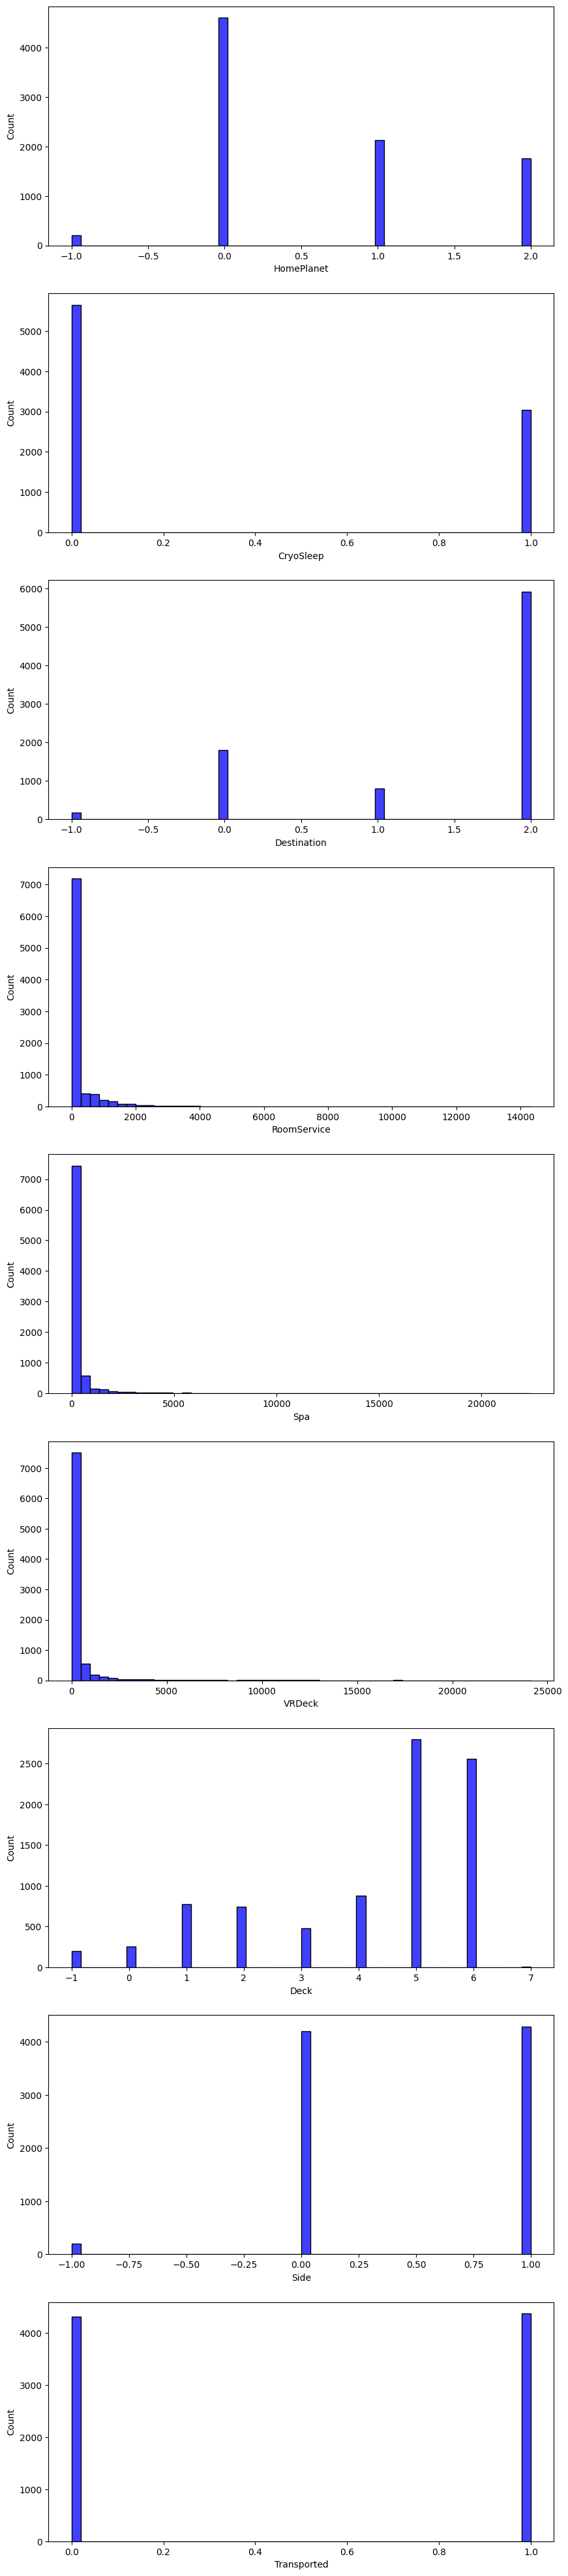

In [159]:
fig, ax = plt.subplots(9,1,  figsize=(10, 10))
plt.subplots_adjust(top = 4)

sns.histplot(TRAIN_FINAL['HomePlanet'], color='b', bins=50, ax=ax[0]);
sns.histplot(TRAIN_FINAL['CryoSleep'], color='b', bins=50, ax=ax[1]);
sns.histplot(TRAIN_FINAL['Destination'], color='b', bins=50, ax=ax[2]);
sns.histplot(TRAIN_FINAL['RoomService'], color='b', bins=50, ax=ax[3]);
sns.histplot(TRAIN_FINAL['Spa'], color='b', bins=50, ax=ax[4]);
sns.histplot(TRAIN_FINAL['VRDeck'], color='b', bins=50, ax=ax[5]);
sns.histplot(TRAIN_FINAL['Deck'], color='b', bins=50, ax=ax[6]);
sns.histplot(TRAIN_FINAL['Side'], color='b', bins=50, ax=ax[7]);
sns.histplot(TRAIN_FINAL['Transported'], color='b', bins=50, ax=ax[8]);

Check if the dataset is imbalanced

In [160]:
number_1 = TRAIN_FINAL.Transported.sum()
number_0 = TRAIN_FINAL.shape[0] - number_1

print("Number of 0's: ", number_0)
print("Number of 1's: ", number_1)

Number of 0's:  4315
Number of 1's:  4378


In [162]:
X = TRAIN_FINAL.loc[:, 'HomePlanet': 'Side']
y = TRAIN_FINAL.loc[:, 'Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forests:

In [167]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=0)

In [168]:
y_pred = clf_rf.predict(X_val)
accuracy_score(y_val, y_pred)

0.7642323174238068

Nearest Neighbors

In [169]:
neigh = KNeighborsClassifier(n_neighbors=4, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [170]:
y_pred = neigh.predict(X_val)
accuracy_score(y_val, y_pred)

0.7446808510638298